(membership_ntbk)=

# Membership probabilities

In [1]:
%config InlineBackend.figure_format = "retina"

**ASteCA** includes a [asteca.membership](https://asteca.readthedocs.io/en/latest/apidocs/asteca/asteca.membership.html) class designed to estimate membership probabilities for stars in an observed field. The class currently supports two methods `bayesian` and `fastmp`, as described in the [Membership estimation](https://asteca.readthedocs.io/en/latest/basic/membership.html) section.

Both methods require some parameters to be obtained before they can be used. In both cases the center and approximated number of true cluster members values need to be estimated. The `bayesian` method also requires an approximated cluster radius value.

In the following example we will show how these two methods can be applied on an observed field. We begin by loading the required packages and our field data file, and use this data to create an `asteca.cluster` object which we call `my_field`:

In [3]:
import asteca
import pandas as pd
import matplotlib.pyplot as plt

field_df = pd.read_csv("../_static/field.csv")

my_field = asteca.cluster(
    ra=field_df["RA_ICRS"],
    dec=field_df["DE_ICRS"],
    pmra=field_df["pmRA"],
    pmde=field_df["pmDE"],
    plx=field_df["Plx"],
    e_pmra=field_df["e_pmRA"],
    e_pmde=field_df["e_pmDE"],
    e_plx=field_df["e_Plx"],
)


Instantiating cluster...
Cluster object generated


We can generate a simple `(ra, dec)` plot to see that this is indeed an observed field and not a data file with the cluster member's already identified.

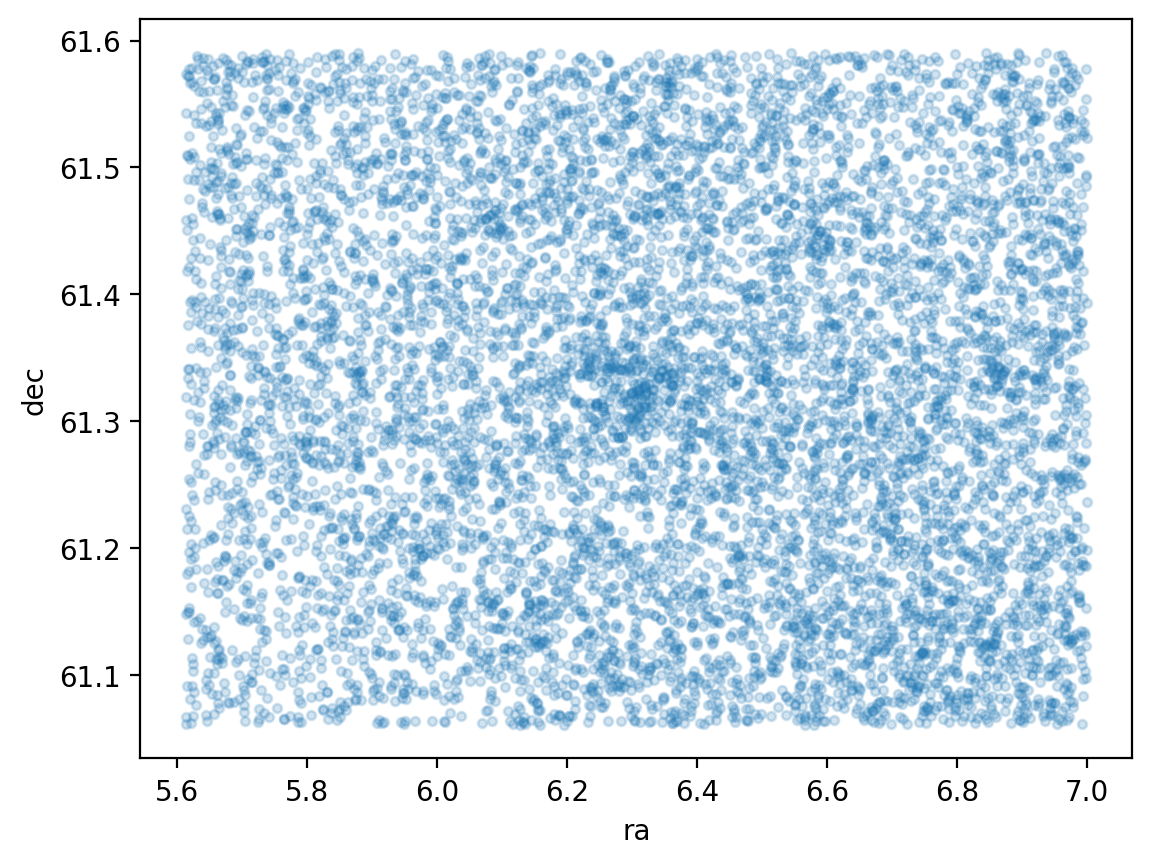

In [4]:
plt.scatter(my_field.ra, my_field.dec, alpha=.2, s=10)
plt.xlabel("ra")
plt.ylabel("dec");

## fastMP method

Before running the `fastmp` method we need to estimate the center and approximated number of members for the cluster. The number of members in the cluster is a crucial parameter in the estimation of membership probabilities. **ASteCA** currently contains [two methods](https://asteca.readthedocs.io/en/latest/apidocs/asteca/asteca.cluster.html#asteca.cluster.Cluster.get_nmembers) to perform this estimation. We use here the default methods both to estimate the center and the number of member stars.

In [5]:
# Estimate the cluster's center coordinates, use the default algorithm
my_field.get_center()

# Estimate the number of cluster members, use the default algorithm
my_field.get_nmembers()


Center coordinates found

Number of members estimated


With the required parameters loaded in the `my_field` object, we can instantiate a `membership` object as follows:

In [6]:
# Define a `membership` object
memb = asteca.membership(my_field, verbose=2)


Membership object generated
N_cluster      : 600
Random seed    : None


Now all we have to do is call the `fastmp` method to obtain the membership probabilities for all the stars in the observed frame:

In [7]:
# Run `fastmp` method
probs_fastmp = memb.fastmp()


Running fastMP...
lonlat_c       : (119.7908, -1.3899)
pms_c          : (-2.811, -1.070)
plx_c          : 0.288
fixed_centers  : False
N_cluster      : 600
N_resample     : 1000
Convergence reached at 96 runs


Finally we plot the CMD of the field, coloring the stars according to their membership probabilities (only those with P>50%):

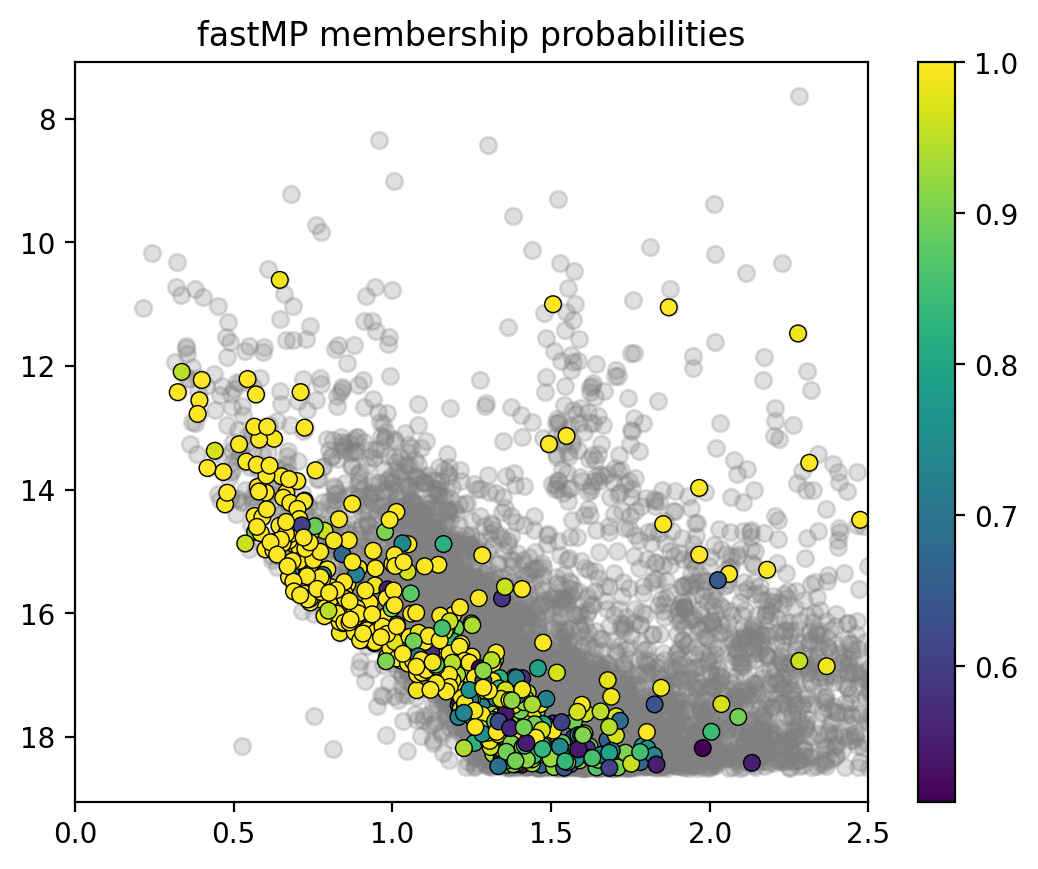

In [8]:
# Plot CMD
plt.title("fastMP membership probabilities")
plt.scatter(field_df['BP-RP'], field_df['Gmag'], c='grey', alpha=.25)
msk = probs_fastmp > 0.5
plt.scatter(field_df['BP-RP'][msk], field_df['Gmag'][msk], c=probs_fastmp[msk], ec='k', lw=.5)
plt.gca().invert_yaxis()
plt.xlim(0, 2.5)
plt.colorbar();

## Bayesian method

As stated in the in the [Membership estimation](https://asteca.readthedocs.io/en/latest/basic/membership.html) section, the `bayesian` method shold only be preferred over `fastmp` when there is no proper motions and parallax data available. In those cases, the `fastmp` method will most likely give better results.

We will show here how the `bayesian` method can be used with photometric data exclusively. We thus re-instantiate a `cluster` object without proper motions and parallax data:

In [9]:
my_field = asteca.cluster(
    ra=field_df["RA_ICRS"],
    dec=field_df["DE_ICRS"],
    magnitude=field_df["Gmag"],
    e_mag=field_df["e_Gmag"],
    color=field_df["BP-RP"],
    e_color=field_df["e_BP-RP"],
    verbose=2
)


Instantiating cluster...
Columns read   : RA, DEC, Magnitude, e_mag, Color, e_color
N_stars        : 8683
N_clust_min    : 25
N_clust_max    : 5000
Cluster object generated


Now we need to estimate the center coordinates and number of members (just like with `fastmp`) and in addition we need to add a `radius` argument (which is not required for `fastmp`):

In [10]:
# Estimate the cluster's center coordinates, using the `kde_2d` algorithm and (RA, DEC) data
my_field.get_center("kde_2d", data_2d=("radec"))

# Add a radius attribute manually (there is no method included in ASteCA to estimate
# the radius parameter yet)
my_field.radius = 0.09  # in degrees

# Estimate the number of cluster members, using the `density` algorithm
my_field.get_nmembers("density")


Center coordinates found
radec_c        : (6.3142, 61.3262)

Number of members estimated
N_cluster      : 247


Now we can instantiate the `membership` object and obtain the membership probabilities using the `bayesian` method:


Membership object generated
N_cluster      : 247
Random seed    : None

Running Bayesian DA...
radec_c        : (6.3142, 61.3262)
radius         : 0.0900 [deg]
N_cluster      : 247
N_runs         : 1000
Convergence reached at 92 runs


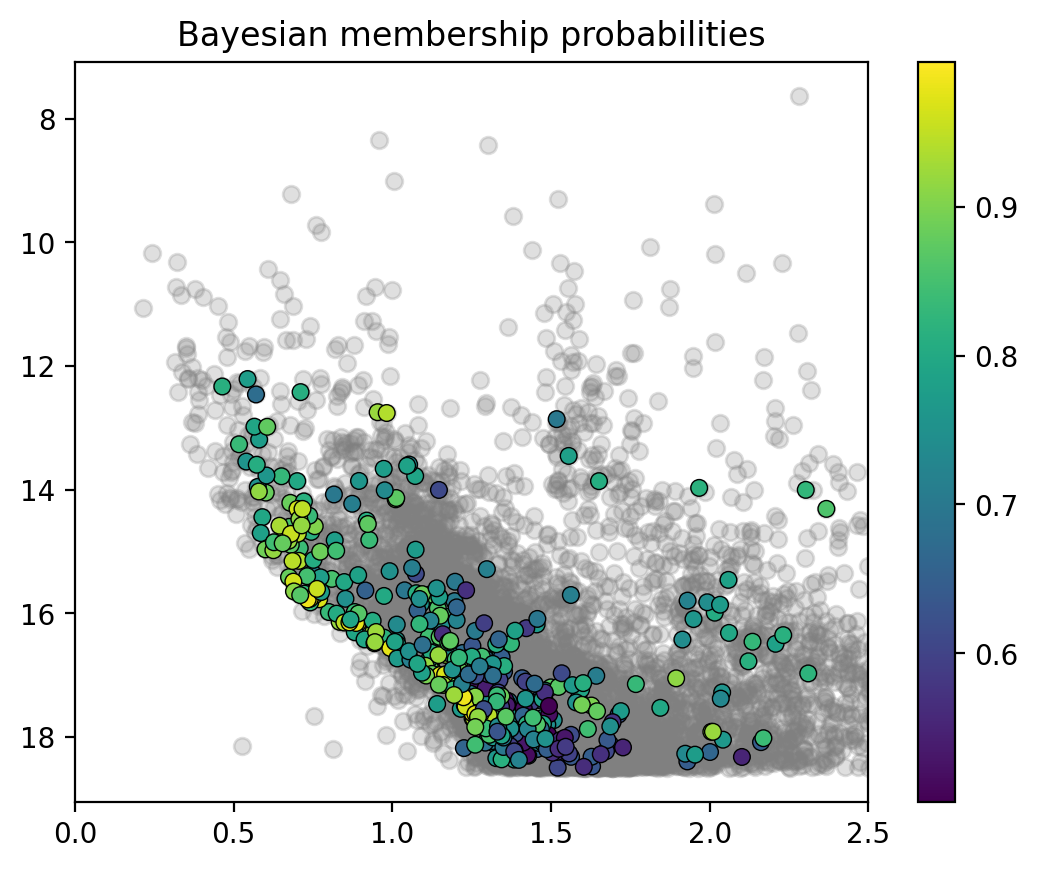

In [11]:
# Define a `membership` object
memb = asteca.membership(my_field, verbose=2)

# Run `bayesian` method
probs_bayes = memb.bayesian()

# Plot CMD
plt.title("Bayesian membership probabilities")
plt.scatter(field_df['BP-RP'], field_df['Gmag'], c='grey', alpha=.25)
msk = probs_bayes > 0.5
plt.scatter(field_df['BP-RP'][msk], field_df['Gmag'][msk], c=probs_bayes[msk], ec='k', lw=.5)
plt.gca().invert_yaxis()
plt.xlim(0, 2.5)
plt.colorbar();

A side-by-side plot of the CMDs shows that the stars with P>50% selected by each of the methods are not necessarily the same, as is their assigned membership probabilities.

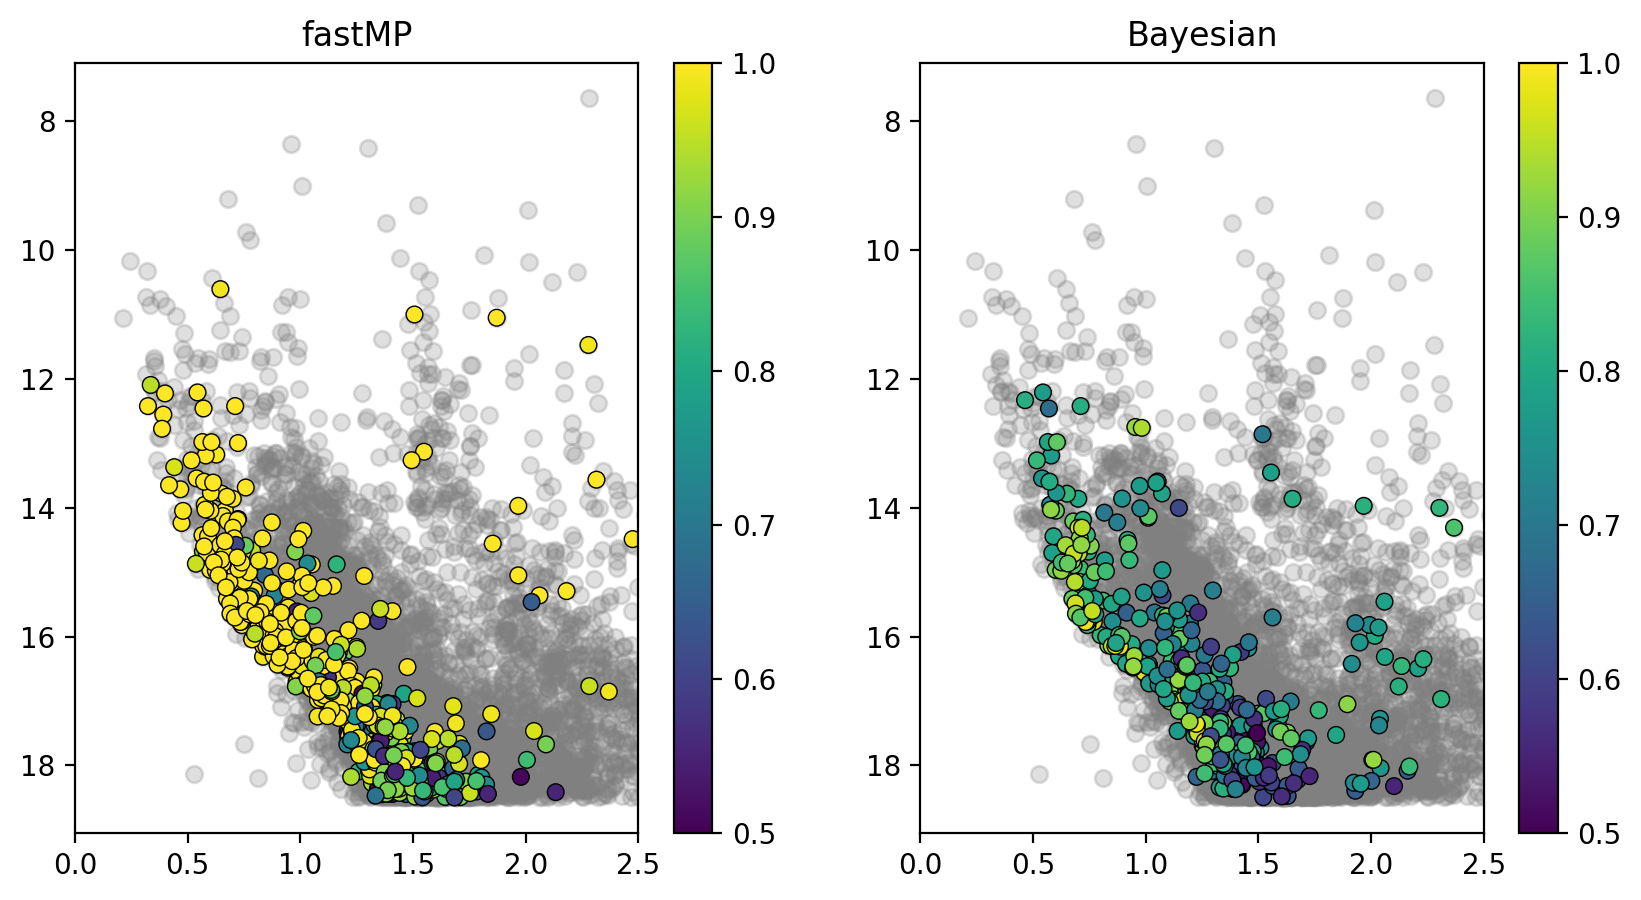

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# fastMP membership
ax1.set_title("fastMP")
ax1.scatter(field_df['BP-RP'], field_df['Gmag'], c='grey', alpha=.25)
msk = probs_fastmp > 0.5
im1= ax1.scatter(field_df['BP-RP'][msk], field_df['Gmag'][msk], c=probs_fastmp[msk], ec='k', lw=.5, vmin=0.5, vmax=1)
ax1.invert_yaxis()
ax1.set_xlim(0, 2.5)
fig.colorbar(im1, ax=ax1)

# Bayesian memberhsip
ax2.set_title("Bayesian")
ax2.scatter(field_df['BP-RP'], field_df['Gmag'], c='grey', alpha=.25)
msk = probs_bayes > 0.5
im2 = ax2.scatter(field_df['BP-RP'][msk], field_df['Gmag'][msk], c=probs_bayes[msk], ec='k', lw=.5, vmin=0.5, vmax=1)
ax2.invert_yaxis()
ax2.set_xlim(0, 2.5)
fig.colorbar(im2, ax=ax2);